# BendyBevo
This notebook is intended to be a demonstration of the ability to solve equations directly on the mesh generated from a bitmap image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils import bitmapMeshHelper, gmsh2meshio

import dolfin as dl
import ufl

import gmsh
from mpi4py import MPI
import meshio
import pyvista
pyvista.start_xvfb()

## Step 1: Mesh Creation.
- Load image.
- Threshold image to produce a bitmap.
- Extract image boundary.
- Create mesh at specified location with specified scale.
- Load mesh into Dolfin and visualize it.

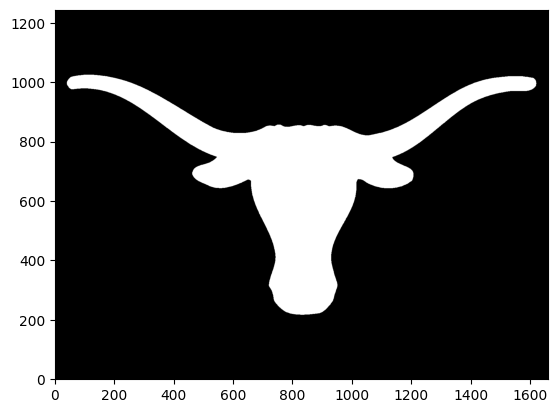

In [2]:
IMPATH = "longhorns.jpg"
im = cv2.imread(IMPATH, cv2.IMREAD_GRAYSCALE)
# Threshold the image to create a bitmap.
lh = ((im > 200) * 1).astype(np.uint8)[::-1]
plt.imshow(lh, cmap=plt.cm.gray, origin="lower")
plt.show()

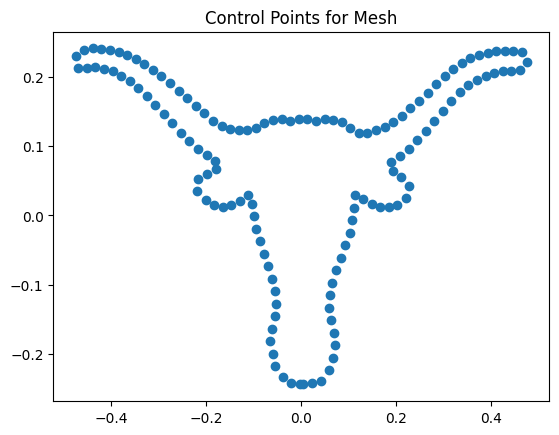

In [3]:
CX = 0
CY = 0
ORIGIN = np.array([CX, CY])
SCALE = 1. / np.max(lh.shape)
MSHMESH = "mesh/horns3.msh"
XDMFMESH = "mesh/horns3.xdmf"

LHMH = bitmapMeshHelper(data=lh, scale=SCALE, origin=ORIGIN)
boundary = LHMH.getBoundary(method="opencv")

# try downsampling boundary
DOWNSAMPLE = 30
boundary = boundary[::DOWNSAMPLE]

plt.scatter(boundary[:,0], boundary[:,1])
plt.title("Control Points for Mesh")
plt.show()

In [4]:
gmsh.initialize()
gdim = 3
mesh_comm = MPI.COMM_WORLD
model_rank = 0
LCAR = 1e3

# Create points
points = [gmsh.model.occ.add_point(x=pt[0], y=pt[1], z=0., meshSize=LCAR) for pt in boundary]
# Create lines.
lines = [gmsh.model.occ.add_line(points[k], points[k+1]) for k in range(len(points)-1)]
lines.append(gmsh.model.occ.add_line(points[-1], points[0]))

#  ------------------
# Create (sp)lines.
# lines = [gmsh.model.occ.add_spline([points[k], points[k+1]]) for k in range(len(points)-1)]
# lines.append(gmsh.model.occ.add_spline([points[-1], points[0]]))
#  ------------------

# Create the curve loop.
bndryloop = [gmsh.model.occ.add_curve_loop(lines)]
# Add the surface.
s = gmsh.model.occ.add_plane_surface(bndryloop)

# Extrude Bevo. (see `t1.py` and `t3.py` for more details)
# bevo = gmsh.model.addPhysicalGroup(1, [s])
# gmsh.model.setPhysicalName(1, bevo, "bevo")

vol = gmsh.model.occ.extrude([(2, 1)], 0, 0, 0.1, [2, 2], [0.5, 1])

gmsh.model.occ.synchronize()

# We can constraint the min and max element sizes to stay within reasonnable
# values (see `t10.py' for more details):
gmsh.option.setNumber("Mesh.MeshSizeMin", 0.1)
gmsh.option.setNumber("Mesh.MeshSizeMax", 1.)

In [5]:
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
gmsh.write(MSHMESH)
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info    : [ 10%] Meshing curve 22 (Line)
Info    : [ 10%] Meshing curve 23 (Line)
Info    : [ 10%] Meshing curve 24 (Line)
I

### Mesh creation using GMSH only instead of pygmsh.

In [6]:
mesh_from_file = meshio.read(MSHMESH)
cell_type="tetra"

cells = mesh_from_file.get_cells_type(cell_type)
cell_data = mesh_from_file.get_cell_data("gmsh:geometrical", cell_type)
points = mesh_from_file.points
out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})

In [7]:
# ------ Convert mesh to xdmf for reading in dolfin ------ # 
mesh_from_file = meshio.read(MSHMESH)
triangle_mesh = gmsh2meshio(mesh_from_file, "tetra", prune_z=False)
meshio.write(XDMFMESH, triangle_mesh)

mesh = dl.Mesh()
f = dl.XDMFFile(dl.MPI.comm_world, XDMFMESH)
f.read(mesh)
f.close()

mesh

## Step 2: Set up Elasticity Problem.

In [8]:
# Parameters.
mu = 1.
rho = 1.

beta = 1.25
lambda_ = beta

LOAD = 5e-5
CLAMP = dl.Constant((0., 0., 0.))

# Define the function space.
V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)

# Define the boundary condition.
nose = 'on_boundary && x[1]<-0.2'
bc = dl.DirichletBC(V, CLAMP, nose)

# Define the point loads.
lefthorn = dl.Point(-0.42, 0.23, 0.)
load1 = dl.PointSource(V.sub(2), lefthorn, LOAD)
righthorn = dl.Point(0.44, 0.23, 0.1)
load2 = dl.PointSource(V.sub(2), righthorn, LOAD)

# horns = 'on_boundary && x[1]>0.1'
# bc = dl.DirichletBC(V, CLAMP, horns)
# load1 = dl.PointSource(V.sub(2), dl.Point(0., -0.2, 0), 100*LOAD)

# Define strain and stress.
def epsilon(u):
    return 0.5*(dl.nabla_grad(u) + dl.nabla_grad(u).T)

def sigma(u):
    return lambda_*dl.div(u)*dl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

### Define the Variational Problem

In [9]:
u = dl.TrialFunction(V)
v = dl.TestFunction(V)
f = dl.Constant((0., 0., 0.))
ds = dl.Measure("ds", mesh)

# Variational forms.
a = dl.inner(sigma(u), epsilon(v))*ufl.dx
l = dl.dot(f, v)*ds

# System assembly.
K = dl.assemble(a)
b = dl.assemble(l)

# Apply loads.
load1.apply(b)
load2.apply(b)

# Apply boundary conditions.
bc.apply(K)
bc.apply(b)

### Solve the linear system and write output.

In [10]:
usol = dl.Function(V, name="Displacement")
dl.solve(K, usol.vector(), b)
with dl.XDMFFile("results/bendybevo3d.xdmf") as fid:
    # fid.write_checkpoint(usol, function_name="Displacement")
    fid.write(usol)

## Step 3: Post Process Results

In [11]:
SOLPATH = "results/bendybevo3d.xdmf"
SAVE_FIG = False
FIGNAME = "getbent.png"
bevo = pyvista.read("results/bendybevo3d.xdmf")

/storage/graham/miniconda3/envs/fenics2019/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


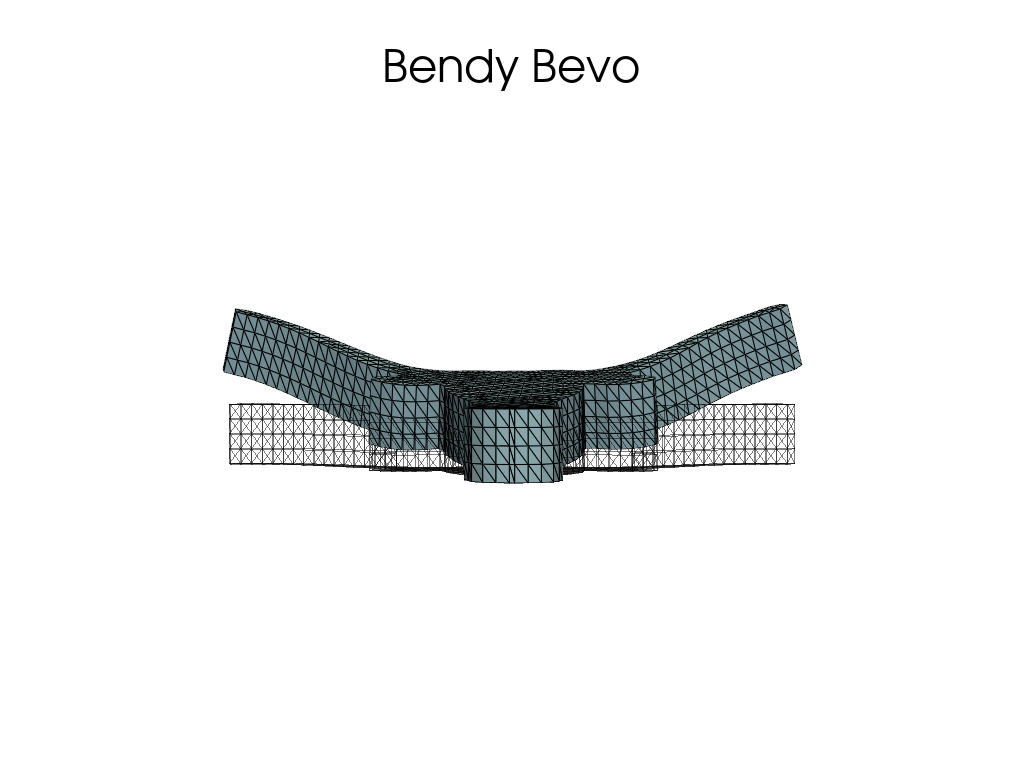

In [12]:
plotter = pyvista.Plotter()
warped = bevo.warp_by_vector("Displacement")
plotter.add_mesh(bevo,
            style="wireframe",
            color="black",
            line_width=0.5,
            opacity=0.3
            )
plotter.add_mesh(warped,
            show_edges=True,
            scalar_bar_args={"title": "Deformation Magnitude"}
            )
plotter.add_title(f"Bendy Bevo")
plotter.view_xz()
if not SAVE_FIG:
    plotter.show(jupyter_backend="trame", auto_close=False)
else:
    plotter.show(jupyter_backend="none", screenshot="hornsup.png")